## Importing Libraries

In [2]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pickle

## Reading the input data

In [3]:
drought_df = pd.read_csv('../data/test_timeseries.csv')
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2019-01-01,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,...,14.63,1.20,1.50,0.79,0.71,2.74,4.01,1.23,2.78,0.0
1,1001,2019-01-02,4.94,100.48,8.65,13.05,11.83,11.74,17.76,9.54,...,13.06,1.02,1.35,0.32,1.03,2.13,3.37,0.56,2.81,NaN
2,1001,2019-01-03,20.74,100.03,8.59,12.12,11.67,11.67,13.74,10.44,...,12.12,1.83,4.23,0.34,3.88,3.41,7.49,0.72,6.77,NaN
3,1001,2019-01-04,16.17,99.47,7.93,11.80,10.38,9.59,18.19,5.44,...,11.72,3.75,5.25,2.34,2.91,6.78,9.61,4.90,4.71,NaN
4,1001,2019-01-05,0.01,100.39,5.32,7.91,4.73,4.71,14.37,3.68,...,7.75,2.32,2.90,1.69,1.21,4.42,5.87,3.15,2.72,NaN


## Initial exploration and data cleaning (Data Wrangling)

In [5]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271948 entries, 0 to 2271947
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 364.0+ MB


In [6]:
drought_df.isnull().sum()

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

### Missing value Treatment

In [7]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.
drought_df = drought_df.dropna()
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

### Reformatting the data

In [8]:
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [9]:
drought_df['year'] = pd.DatetimeIndex(drought_df['date']).year
drought_df['month'] = pd.DatetimeIndex(drought_df['date']).month
drought_df['day'] = pd.DatetimeIndex(drought_df['date']).day
drought_df['score'] = drought_df['score'].round().astype(int)
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int64
month            int64
day              int64
dtype: object

In [10]:
drought_df['fips'].nunique()

3108

In [11]:
drought_df['score'].round().value_counts()

0    247720
1     42486
2     22159
3      9590
4      3578
5       807
Name: score, dtype: int64

## Exploraory Data Analysis

### Univariate Analysis - Descriptive statistics

In [12]:
# Descriptive statistics
display(drought_df.describe()) # For numeric columns
display(drought_df.describe(include=['object'])) # For Categorical columns
print("\nSkewness: \n", drought_df.skew(axis = 0, skipna = True))
print("\nKurtosis: \n", drought_df.kurtosis(axis = 0, skipna = True))

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
count,326340.000000,326340.000000,326340.000000,326340.00000,326340.000000,326340.000000,326340.000000,326340.000000,326340.000000,326340.000000,...,326340.000000,326340.000000,326340.00000,326340.000000,326340.000000,326340.000000,326340.000000,326340.000000,326340.000000,326340.000000
mean,30670.376770,2.773609,96.664013,8.19353,12.809354,7.637028,7.681143,18.447932,7.651906,10.796031,...,1.874162,3.260994,5.45473,7.736035,3.049395,4.686642,0.410373,2019.495238,6.552381,15.733333
std,14979.130338,6.271320,5.439992,4.95683,10.990227,10.524875,10.260454,11.575784,10.755246,3.835380,...,1.275018,1.934575,2.20415,2.747975,2.024862,2.163710,0.857390,0.499978,3.480511,8.851451
min,1001.000000,0.000000,66.930000,0.15000,-34.690000,-37.840000,-34.830000,-28.350000,-41.960000,0.120000,...,0.000000,0.260000,0.70000,1.270000,0.000000,0.530000,0.000000,2019.000000,1.000000,1.000000
25%,19044.500000,0.000000,95.860000,3.91000,4.380000,-0.360000,-0.240000,9.880000,-0.530000,8.060000,...,0.950000,1.800000,3.80000,5.660000,1.450000,3.140000,0.000000,2019.000000,4.000000,8.000000
50%,29212.000000,0.200000,98.310000,7.05000,13.950000,8.200000,8.060000,20.290000,8.140000,10.670000,...,1.630000,2.810000,5.11000,7.280000,2.720000,4.250000,0.000000,2019.000000,7.000000,16.000000
75%,46007.500000,2.540000,99.970000,12.19000,22.070000,16.830000,16.690000,27.790000,16.630000,13.420000,...,2.520000,4.250000,6.77000,9.380000,4.300000,5.770000,0.000000,2020.000000,10.000000,23.000000
max,56043.000000,234.800000,103.790000,21.80000,39.110000,26.710000,26.620000,46.830000,32.320000,26.180000,...,15.440000,19.110000,20.33000,28.740000,18.370000,22.850000,5.000000,2020.000000,12.000000,31.000000


,date
count,326340
unique,105
top,2019-01-01
freq,3108



Skewness: 
 fips          -0.077368
PRECTOT        4.672804
PS            -2.144200
QV2M           0.493964
T2M           -0.416752
T2MDEW        -0.365210
T2MWET        -0.302190
T2M_MAX       -0.456988
T2M_MIN       -0.368619
T2M_RANGE      0.157075
TS            -0.391106
WS10M          1.037704
WS10M_MAX      0.908820
WS10M_MIN      1.285984
WS10M_RANGE    1.312437
WS50M          0.806169
WS50M_MAX      0.892746
WS50M_MIN      0.815506
WS50M_RANGE    1.257341
score          2.385498
year           0.019049
month         -0.007572
day            0.002928
dtype: float64

Kurtosis: 
 fips           -1.100134
PRECTOT        37.337228
PS              4.856370
QV2M           -0.919667
T2M            -0.545738
T2MDEW         -0.612593
T2MWET         -0.723959
T2M_MAX        -0.522698
T2M_MIN        -0.368068
T2M_RANGE      -0.340927
TS             -0.522508
WS10M           1.078433
WS10M_MAX       0.695609
WS10M_MIN       2.584700
WS10M_RANGE     2.278172
WS50M           0.607371
WS50M_M

In [13]:
column_list = list(drought_df.columns)
column_list

['fips',
 'date',
 'PRECTOT',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE',
 'score',
 'year',
 'month',
 'day']

### Univariate Analysis - Distribution of continuous variables

In [14]:
measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = drought_df[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

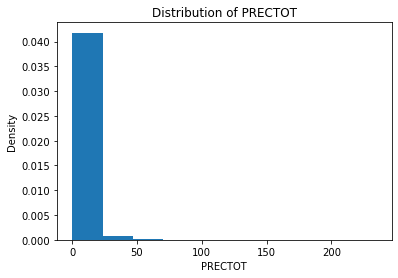

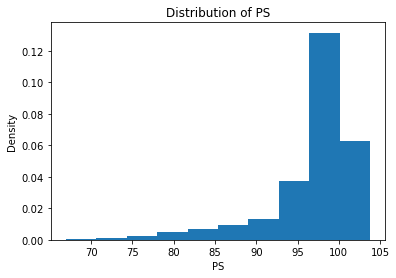

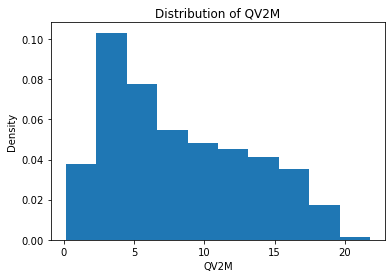

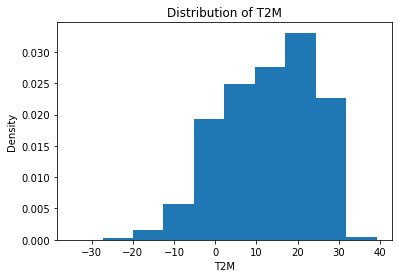

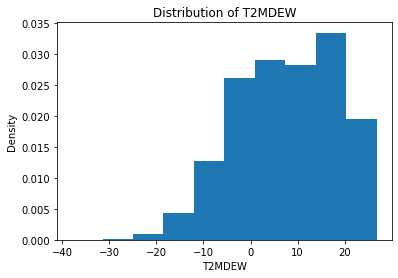

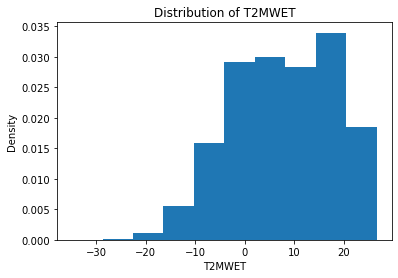

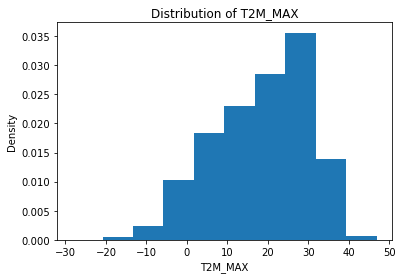

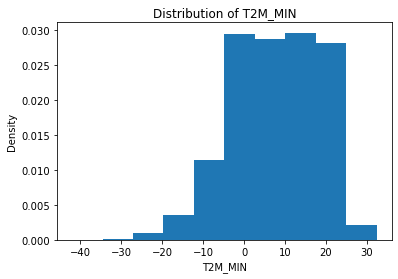

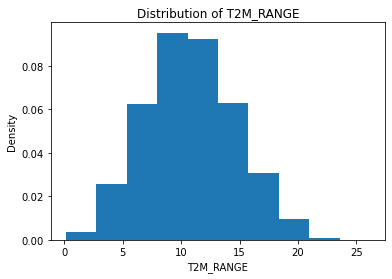

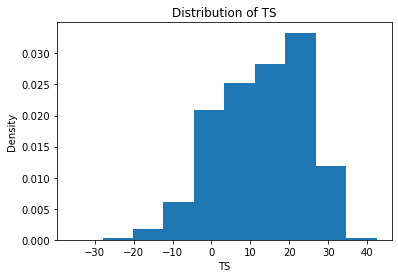

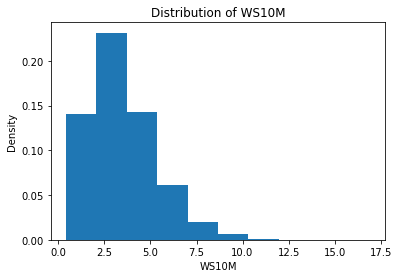

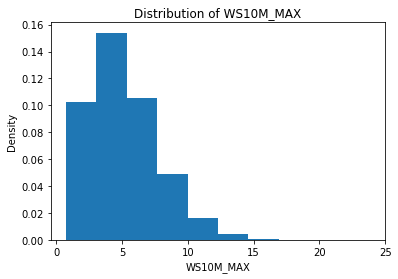

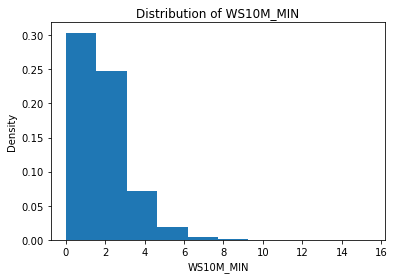

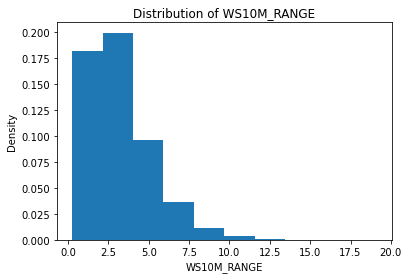

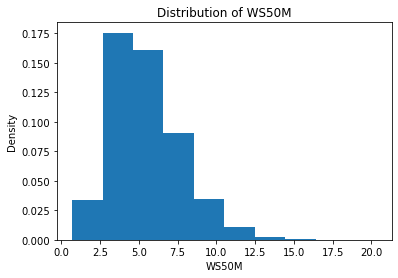

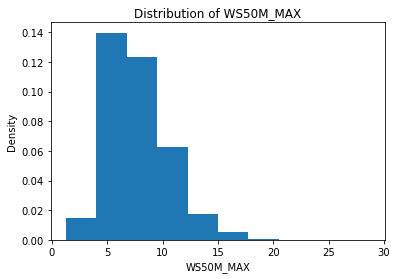

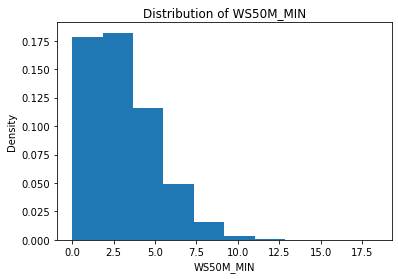

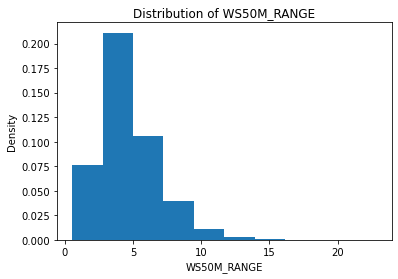

In [15]:
for col_name in measures_column_list:
    plt.figure()
    plt.hist(drought_df_measures[col_name], density = True)
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

## Outlier Treatment

### Identifying Outliers

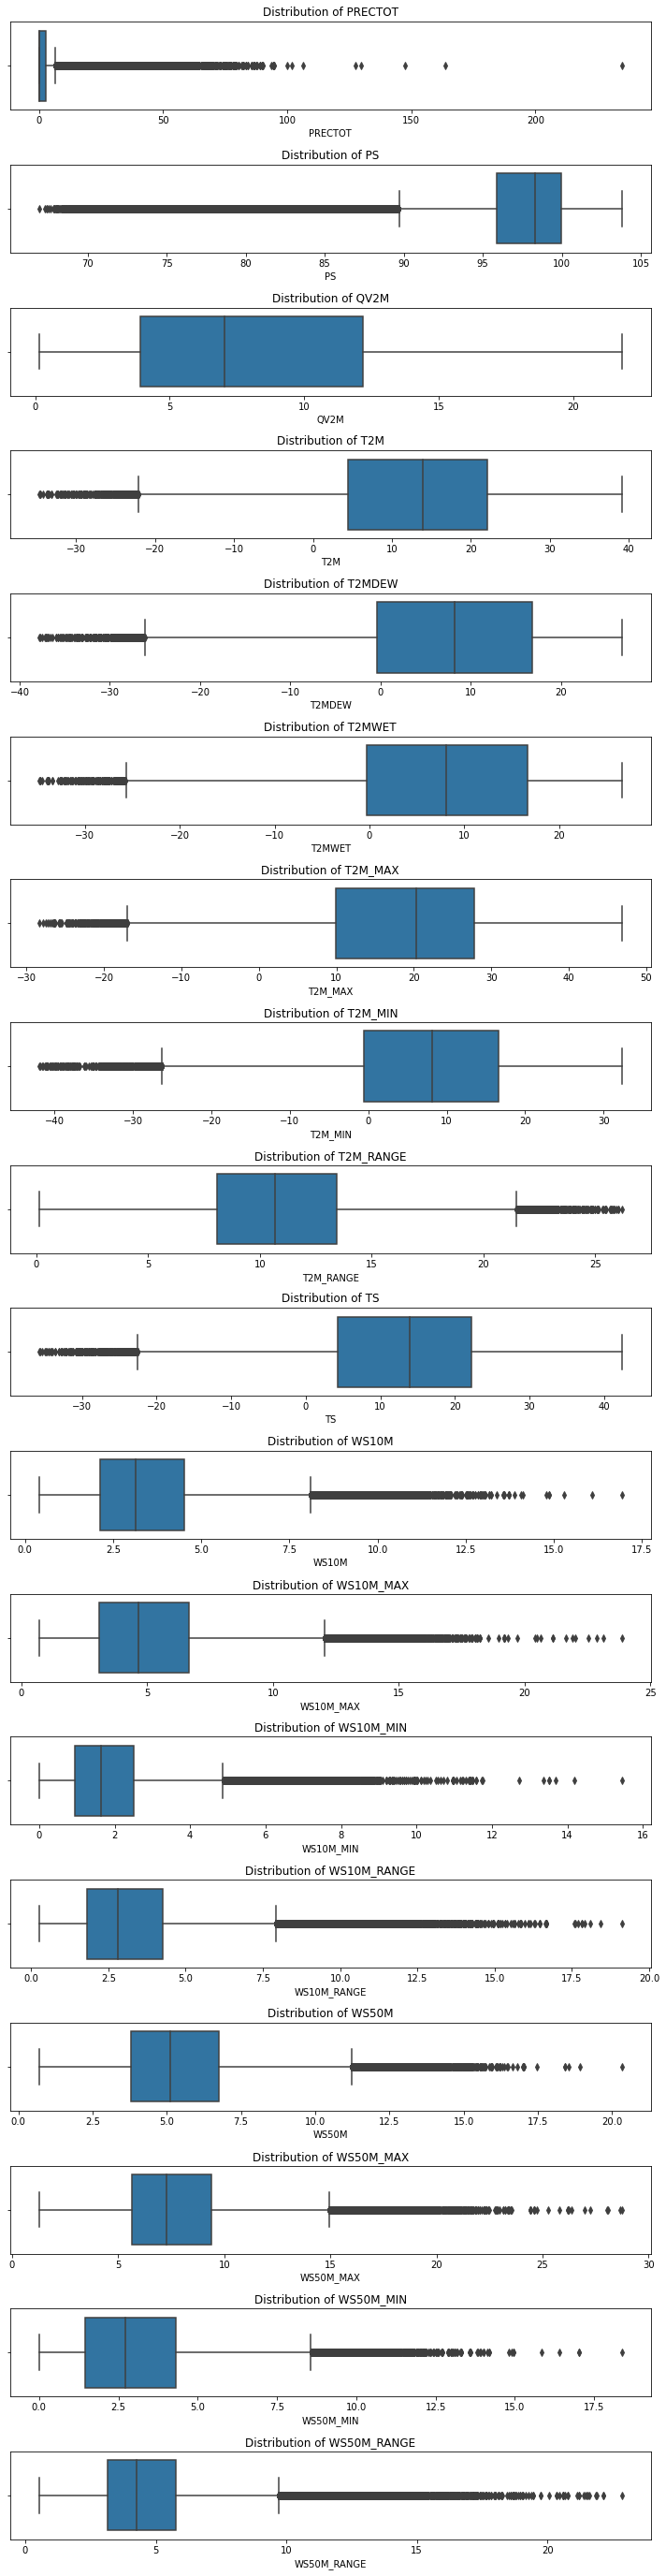

In [16]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

In [17]:
print('Total rows = ',len(drought_df_measures.index))
for i in drought_df_measures.select_dtypes(exclude = ['object']).columns:
    print ('Number of values beyong standard outlier limit in ', i)
    print(len(drought_df_measures[(drought_df_measures[i] > drought_df_measures[i].mean() + 3*drought_df_measures[i].std()) | (drought_df_measures[i] < drought_df_measures[i].mean() - 3*drought_df_measures[i].std())]))

Total rows =  326340
Number of values beyong standard outlier limit in  PRECTOT
7489
Number of values beyong standard outlier limit in  PS
8693
Number of values beyong standard outlier limit in  QV2M
0
Number of values beyong standard outlier limit in  T2M
678
Number of values beyong standard outlier limit in  T2MDEW
628
Number of values beyong standard outlier limit in  T2MWET
420
Number of values beyong standard outlier limit in  T2M_MAX
604
Number of values beyong standard outlier limit in  T2M_MIN
965
Number of values beyong standard outlier limit in  T2M_RANGE
291
Number of values beyong standard outlier limit in  TS
675
Number of values beyong standard outlier limit in  WS10M
3663
Number of values beyong standard outlier limit in  WS10M_MAX
2737
Number of values beyong standard outlier limit in  WS10M_MIN
4620
Number of values beyong standard outlier limit in  WS10M_RANGE
4283
Number of values beyong standard outlier limit in  WS50M
2682
Number of values beyong standard outlier l

### Removing values beyond the standard outlier limit

In [18]:
drought_df = drought_df[(drought_df['PRECTOT'] <= drought_df['PRECTOT'].mean() + 3*drought_df['PRECTOT'].std()) &
        (drought_df['PRECTOT'] >= drought_df['PRECTOT'].mean() - 3*drought_df['PRECTOT'].std())]

drought_df = drought_df[(drought_df['PS'] <= drought_df['PS'].mean() + 3*drought_df['PS'].std()) &
        (drought_df['PS'] >= drought_df['PS'].mean() - 3*drought_df['PS'].std())]

drought_df = drought_df[(drought_df['QV2M'] <= drought_df['QV2M'].mean() + 3*drought_df['QV2M'].std()) &
        (drought_df['QV2M'] >= drought_df['QV2M'].mean() - 3*drought_df['QV2M'].std())]

drought_df = drought_df[(drought_df['T2M'] <= drought_df['T2M'].mean() + 3*drought_df['T2M'].std()) &
        (drought_df['T2M'] >= drought_df['T2M'].mean() - 3*drought_df['T2M'].std())]

drought_df = drought_df[(drought_df['T2MDEW'] <= drought_df['T2MDEW'].mean() + 3*drought_df['T2MDEW'].std()) &
        (drought_df['T2MDEW'] >= drought_df['T2MDEW'].mean() - 3*drought_df['T2MDEW'].std())]

drought_df = drought_df[(drought_df['T2MWET'] <= drought_df['T2MWET'].mean() + 3*drought_df['T2MWET'].std()) &
        (drought_df['T2MWET'] >= drought_df['T2MWET'].mean() - 3*drought_df['T2MWET'].std())]

drought_df = drought_df[(drought_df['T2M_MAX'] <= drought_df['T2M_MAX'].mean() + 3*drought_df['T2M_MAX'].std()) &
        (drought_df['T2M_MAX'] >= drought_df['T2M_MAX'].mean() - 3*drought_df['T2M_MAX'].std())]

drought_df = drought_df[(drought_df['T2M_MIN'] <= drought_df['T2M_MIN'].mean() + 3*drought_df['T2M_MIN'].std()) &
        (drought_df['T2M_MIN'] >= drought_df['T2M_MIN'].mean() - 3*drought_df['T2M_MIN'].std())]

drought_df = drought_df[(drought_df['T2M_RANGE'] <= drought_df['T2M_RANGE'].mean() + 3*drought_df['T2M_RANGE'].std()) &
        (drought_df['T2M_RANGE'] >= drought_df['T2M_RANGE'].mean() - 3*drought_df['T2M_RANGE'].std())]

drought_df = drought_df[(drought_df['TS'] <= drought_df['TS'].mean() + 3*drought_df['TS'].std()) &
        (drought_df['TS'] >= drought_df['TS'].mean() - 3*drought_df['TS'].std())]

drought_df = drought_df[(drought_df['WS10M'] <= drought_df['WS10M'].mean() + 3*drought_df['WS10M'].std()) &
        (drought_df['WS10M'] >= drought_df['WS10M'].mean() - 3*drought_df['WS10M'].std())]

drought_df = drought_df[(drought_df['WS10M_MAX'] <= drought_df['WS10M_MAX'].mean() + 3*drought_df['WS10M_MAX'].std()) &
        (drought_df['WS10M_MAX'] >= drought_df['WS10M_MAX'].mean() - 3*drought_df['WS10M_MAX'].std())]

drought_df = drought_df[(drought_df['WS10M_MIN'] <= drought_df['WS10M_MIN'].mean() + 3*drought_df['WS10M_MIN'].std()) &
        (drought_df['WS10M_MIN'] >= drought_df['WS10M_MIN'].mean() - 3*drought_df['WS10M_MIN'].std())]

drought_df = drought_df[(drought_df['WS10M_RANGE'] <= drought_df['WS10M_RANGE'].mean() + 3*drought_df['WS10M_RANGE'].std()) &
        (drought_df['WS10M_RANGE'] >= drought_df['WS10M_RANGE'].mean() - 3*drought_df['WS10M_RANGE'].std())]

drought_df = drought_df[(drought_df['WS50M'] <= drought_df['WS50M'].mean() + 3*drought_df['WS50M'].std()) &
        (drought_df['WS50M'] >= drought_df['WS50M'].mean() - 3*drought_df['WS50M'].std())]

drought_df = drought_df[(drought_df['WS50M_MAX'] <= drought_df['WS50M_MAX'].mean() + 3*drought_df['WS50M_MAX'].std()) &
        (drought_df['WS50M_MAX'] >= drought_df['WS50M_MAX'].mean() - 3*drought_df['WS50M_MAX'].std())]

drought_df = drought_df[(drought_df['WS50M_MIN'] <= drought_df['WS50M_MIN'].mean() + 3*drought_df['WS50M_MIN'].std()) &
        (drought_df['WS50M_MIN'] >= drought_df['WS50M_MIN'].mean() - 3*drought_df['WS50M_MIN'].std())]

drought_df = drought_df[(drought_df['WS50M_RANGE'] <= drought_df['WS50M_RANGE'].mean() + 3*drought_df['WS50M_RANGE'].std()) &
        (drought_df['WS50M_RANGE'] >= drought_df['WS50M_RANGE'].mean() - 3*drought_df['WS50M_RANGE'].std())]

print('Total rows = ',len(drought_df.index))

Total rows =  292895


### Univariate Analysis - Distribution of categorical variables

In [19]:
categorical_column_list = ['score','year','month','day']
drought_df_categorical = drought_df[['score','year','month','day']]

<Figure size 720x2880 with 0 Axes>

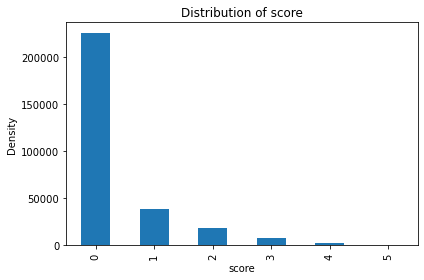

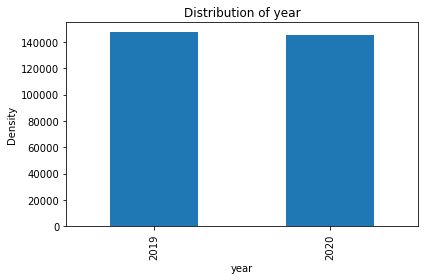

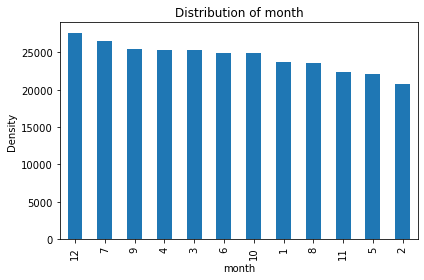

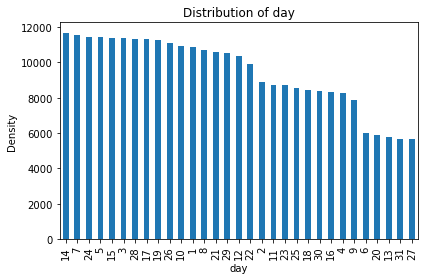

In [20]:
# Distribution of categorical variables
plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    drought_df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.tight_layout()

### Bivariate Analysis

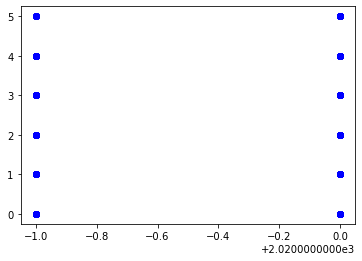

In [21]:
plt.scatter(drought_df['year'], drought_df['score'], c ="blue")
plt.show()

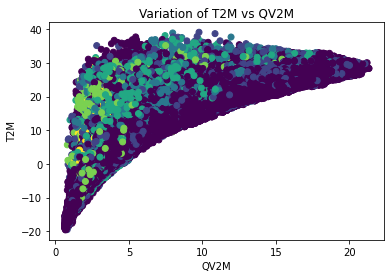

In [20]:
plt.scatter(drought_df['QV2M'], drought_df['T2M'], c =drought_df['score'])
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
plt.show()

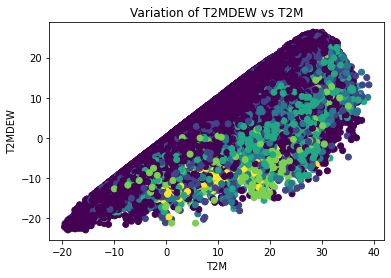

In [21]:
plt.scatter(drought_df['T2M'], drought_df['T2MDEW'], c =drought_df['score'])
plt.xlabel('T2M')
plt.ylabel('T2MDEW')
plt.title('Variation of T2MDEW vs T2M')
plt.show()

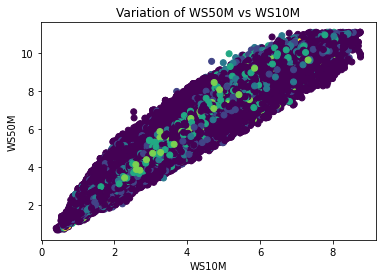

In [22]:
temp_df = drought_df[drought_df['score']==5]
plt.scatter(drought_df['WS10M'], drought_df['WS50M'], c= drought_df['score'])
plt.xlabel('WS10M')
plt.ylabel('WS50M')
plt.title('Variation of WS50M vs WS10M')
plt.show()

### Extracting Dependent and Independent Variables

In [22]:
independent_variables = drought_df.drop('score', 1)
independent_variables = independent_variables.drop('fips', 1)
independent_variables = independent_variables.drop('date', 1)
independent_variables.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,year,month,day
0,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,...,1.50,0.79,0.71,2.74,4.01,1.23,2.78,2019,1,1
7,0.05,100.57,8.75,13.15,12.01,11.98,20.04,9.36,10.68,13.05,...,3.40,1.68,1.72,5.13,6.51,3.67,2.85,2019,1,8
14,0.00,101.07,4.04,3.91,0.94,0.96,9.40,1.02,8.38,3.91,...,2.40,1.36,1.04,3.28,4.13,2.39,1.75,2019,1,15
21,0.03,101.14,4.96,6.03,3.81,3.08,12.43,-1.63,14.06,6.08,...,4.57,2.49,2.07,6.65,8.56,5.01,3.55,2019,1,22
28,5.79,100.36,3.69,2.23,-0.41,-1.03,7.33,-5.19,12.52,2.18,...,4.52,1.71,2.81,5.62,6.96,3.60,3.35,2019,1,29


In [26]:
target = drought_df['score']
target.round().value_counts()
target.head()

0     0
7     0
14    0
21    0
28    0
Name: score, dtype: int32

## Correlation between independent variables for Feature Selection

In [27]:
correlation_plot = drought_df_measures.corr()
correlation_plot.style.background_gradient(cmap = 'RdYlGn')

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.073904,0.225188,0.096873,0.216142,0.214408,0.038072,0.140574,-0.279291,0.095679,0.060851,0.071811,0.032583,0.072911,0.068972,0.073980,0.061379,0.036513
PS,0.073904,1.000000,0.291043,0.176514,0.358778,0.359810,0.119935,0.223182,-0.263869,0.176525,-0.085867,-0.136817,0.024800,-0.196161,-0.044718,-0.090659,0.038125,-0.150822
QV2M,0.225188,0.291043,1.000000,0.883240,0.955312,0.959481,0.823517,0.911682,-0.071054,0.876741,-0.233731,-0.260642,-0.105144,-0.273266,-0.211670,-0.251765,-0.080321,-0.244589
T2M,0.096873,0.176514,0.883240,1.000000,0.922757,0.922069,0.984454,0.983452,0.213421,0.997619,-0.245111,-0.252613,-0.146473,-0.235478,-0.226880,-0.235551,-0.135565,-0.172296
T2MDEW,0.216142,0.358778,0.955312,0.922757,1.000000,0.998329,0.870069,0.941936,-0.015390,0.915961,-0.254511,-0.280128,-0.118626,-0.289993,-0.215461,-0.251430,-0.088088,-0.236895
T2MWET,0.214408,0.359810,0.959481,0.922069,0.998329,1.000000,0.868723,0.943168,-0.022908,0.914939,-0.255874,-0.281876,-0.118760,-0.292202,-0.217338,-0.253734,-0.088828,-0.239129
T2M_MAX,0.038072,0.119935,0.823517,0.984454,0.870069,0.868723,1.000000,0.943626,0.372018,0.981060,-0.260442,-0.261355,-0.167708,-0.232972,-0.235435,-0.232587,-0.160173,-0.145500
T2M_MIN,0.140574,0.223182,0.911682,0.983452,0.941936,0.943168,0.943626,1.000000,0.043793,0.981389,-0.240578,-0.253921,-0.131791,-0.246872,-0.228760,-0.249764,-0.118401,-0.206411
T2M_RANGE,-0.279291,-0.263869,-0.071054,0.213421,-0.015390,-0.022908,0.372018,0.043793,1.000000,0.208961,-0.111422,-0.076762,-0.136600,-0.010862,-0.069088,-0.001590,-0.151410,0.139681
TS,0.095679,0.176525,0.876741,0.997619,0.915961,0.914939,0.981060,0.981389,0.208961,1.000000,-0.229252,-0.237360,-0.133530,-0.223961,-0.216977,-0.224977,-0.127575,-0.166343


#### Attributes QV2M, T2M, T2MDEW, T2MWET, T2M_MAX, T2M_MIN and TS have shown strong positive correlation
#### Similary WS10M, WS10M_MAX and WS10M_MIN have shown a strong positve correlation
#### Likewise, WS50M, WS50M_MAX and WS50M_MIN show strong positive correlation
#### However, from the scatter plots above, we see significant variance between the data points, despite the strong positive correlation. Hence we'll retain all these variables, and try other feature selection methods.

## Splitting into train and test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

In [29]:
print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (234316, 21)
Train target shape (234316,)
Test features shape (58579, 21)
Test target shape (58579,)


## Standardizing the data

In [30]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[-0.53217154,  0.35960201,  0.70283787, ..., -0.99218642,
        -0.75527926,  1.61448675],
       [ 0.48114484,  0.18459972,  1.47146266, ...,  1.00787512,
         0.11598029,  1.38876007],
       [-0.52700156, -3.0091919 , -0.9638643 , ..., -0.99218642,
        -1.04569911,  0.37299003],
       ...,
       [ 0.83270358,  0.06946664, -0.54516606, ..., -0.99218642,
         0.98723984, -1.65855006],
       [-0.53217154, -0.61212119, -1.43919806, ..., -0.99218642,
        -1.04569911, -1.2070967 ],
       [-0.07204319,  0.17078375,  1.4431449 , ...,  1.00787512,
         0.11598029, -0.98137003]])

## Feature Selection using RFE and Random Forest algorithm

In [29]:
model = RandomForestClassifier(n_estimators=10) # n_estimators is the hyperparameter
rfe = RFE(model, n_features_to_select=6) # n_features_to_select is chosen on a trial and error basis
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features = independent_variables.columns[(fit.get_support())]
print(selected_features)

Num Features: 6
Selected Features: [False  True False False False  True  True False  True  True False False
 False False  True False False False False False False]
Feature Ranking: [14  1  7  8  2  1  1  4  1  1 12 11 15  3  1  5 13 10 16  6  9]
Index(['PS', 'T2MWET', 'T2M_MAX', 'T2M_RANGE', 'TS', 'WS50M'], dtype='object')


In [31]:
independent_variables = independent_variables.drop('PRECTOT', 1)
independent_variables = independent_variables.drop('QV2M', 1)
independent_variables = independent_variables.drop('T2M', 1)
independent_variables = independent_variables.drop('T2MWET', 1)
independent_variables = independent_variables.drop('T2M_MIN', 1)
independent_variables = independent_variables.drop('WS10M', 1)
independent_variables = independent_variables.drop('WS10M_MAX', 1)
independent_variables = independent_variables.drop('WS10M_MIN', 1)
independent_variables = independent_variables.drop('WS10M_RANGE', 1)
independent_variables = independent_variables.drop('WS50M_MAX', 1)
independent_variables = independent_variables.drop('WS50M_MIN', 1)
independent_variables = independent_variables.drop('WS50M_RANGE', 1)
independent_variables = independent_variables.drop('year', 1)
independent_variables = independent_variables.drop('month', 1)
independent_variables = independent_variables.drop('day', 1)


independent_variables.head()

X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train features shape (234316, 6)
Train target shape (234316,)
Test features shape (58579, 6)
Test target shape (58579,)


In [53]:
testuser =np.array([100.31,17.93,37.55,15.14,30.07,2.96])
X_testuser = sc.transform(testuser.reshape(1,-1))
X_testuser

array([[ 0.69809326,  0.95423827,  1.63967133,  1.15468081,  1.53145657,
        -1.16948753]])

In [54]:
sc_test= pickle.load(open("RF_classifier_rev_sc.pkl", "rb"))
X_testuser = sc_test.transform(testuser.reshape(1,-1))
X_testuser

array([[ 0.69809326,  0.95423827,  1.63967133,  1.15468081,  1.53145657,
        -1.16948753]])

In [55]:
y_pred_RF_test = RF_classifier.predict(X_testuser)

y_pred_RF_test

array([1])

In [32]:
pickle.dump(sc, open('RF_classifier_rev_sc.pkl', 'wb'))

## Model Development

### Decision Tree Algorithm withot resampling

In [32]:
DT_classifier = tree.DecisionTreeClassifier(criterion='gini')
DT_classifier.fit(X_train,y_train)
y_pred_DT = DT_classifier.predict(X_test)

In [33]:
print('Performance of Decision Tree Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))
print('Accuracy:',accuracy_score(y_test, y_pred_DT))
print('Precision:',precision_score(y_test, y_pred_DT, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_DT, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_DT, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_DT))

Performance of Decision Tree Algorithm without resampling:

[[40317  2886  1071   437   144    25]
 [ 3260  3432   753   203    59     7]
 [ 1076   974  1433   307    56    13]
 [  450   234   364   422    87     8]
 [  133    54    77    93   105    19]
 [   24     8     6     8    15    19]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     44880
           1       0.45      0.44      0.45      7714
           2       0.39      0.37      0.38      3859
           3       0.29      0.27      0.28      1565
           4       0.23      0.22      0.22       481
           5       0.21      0.24      0.22        80

    accuracy                           0.78     58579
   macro avg       0.41      0.41      0.41     58579
weighted avg       0.78      0.78      0.78     58579

Accuracy: 0.7806210416702232
Precision: 0.7773231281037629
Recall: 0.7806210416702232
F1 Score: 0.778936405125209
Cohen Kappa Score: 0.43179465206412493


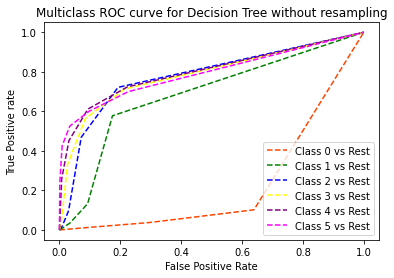

In [34]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_DT, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree without resampling',dpi=300)

### Decision Tree Algorithm without resampling - Hyperparameter Tuning

In [35]:
DT_classifier.get_depth()

46

In [36]:
params = {
          'max_depth': [40, 50, 60, 70, 80],
#           'max_samples_leaf': [, 20, 50, 100],
          'max_features':['log2','sqrt',None]
}

In [37]:
grid_search = GridSearchCV(estimator=DT_classifier, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [38]:
%%time
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Wall time: 27.6 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [40, 50, 60, 70, 80],
                         'max_features': ['log2', 'sqrt', None]},
             scoring='accuracy', verbose=1)

In [39]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
13,1.944660,0.211262,0.052305,0.007834,80,sqrt,"{'max_depth': 80, 'max_features': 'sqrt'}",0.764148,0.764660,0.763021,0.764062,0.763973,0.000595,1
8,3.723381,0.297552,0.038876,0.004424,60,None,"{'max_depth': 60, 'max_features': None}",0.763687,0.762867,0.764574,0.763550,0.763670,0.000608,2
2,3.921267,0.124788,0.043052,0.010878,40,None,"{'max_depth': 40, 'max_features': None}",0.762987,0.763226,0.764096,0.763943,0.763563,0.000468,3
11,4.198296,0.317895,0.042951,0.012011,70,None,"{'max_depth': 70, 'max_features': None}",0.763055,0.763414,0.763704,0.763328,0.763375,0.000231,4
4,1.588753,0.058085,0.044382,0.006684,50,sqrt,"{'max_depth': 50, 'max_features': 'sqrt'}",0.762662,0.763294,0.764284,0.762679,0.763230,0.000660,5


### Decision Tree Algorithm without resampling - Setting the right hyperparameters

In [40]:
DT_classifier = tree.DecisionTreeClassifier(criterion='gini', max_depth=70)
DT_classifier.fit(X_train,y_train)
y_pred_DT = DT_classifier.predict(X_test)

In [41]:
pickle.dump(DT_classifier, open('DT_classifier.pkl', 'wb'))

In [42]:
dt_accuracy = accuracy_score(y_test, y_pred_DT)
dt_precision = precision_score(y_test, y_pred_DT, average='weighted')
dt_recall = recall_score(y_test, y_pred_DT, average='weighted')
dt_f1_score = f1_score(y_test, y_pred_DT, average='weighted')
dt_cohen_kappa_score = cohen_kappa_score(y_test, y_pred_DT)

In [43]:
print('Performance of Decision Tree Algorithm without resampling - After Hyperparameter Tuning:\n')
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))
print('Accuracy:',accuracy_score(y_test, y_pred_DT))
print('Precision:',precision_score(y_test, y_pred_DT, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_DT, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_DT, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_DT))

Performance of Decision Tree Algorithm without resampling - After Hyperparameter Tuning:

[[40246  2945  1090   436   142    21]
 [ 3256  3415   761   220    53     9]
 [ 1079   966  1445   302    55    12]
 [  441   246   363   424    83     8]
 [  135    55    73    95   105    18]
 [   20     7     7    10    16    20]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     44880
           1       0.45      0.44      0.45      7714
           2       0.39      0.37      0.38      3859
           3       0.29      0.27      0.28      1565
           4       0.23      0.22      0.22       481
           5       0.23      0.25      0.24        80

    accuracy                           0.78     58579
   macro avg       0.41      0.41      0.41     58579
weighted avg       0.78      0.78      0.78     58579

Accuracy: 0.7793748612984175
Precision: 0.7767160153194421
Recall: 0.7793748612984175
F1 Score: 0.7780230167566793
Cohen Kappa Score

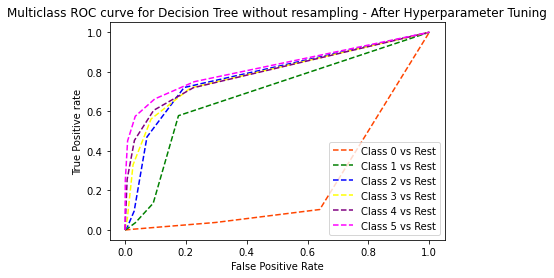

In [44]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_DT, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree without resampling - After Hyperparameter Tuning',dpi=300)

### Random Forest Algorithm without resampling

In [33]:
RF_classifier = RandomForestClassifier(n_estimators = 20, max_depth=70, random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [34]:
print('Performance of RF Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',accuracy_score(y_test, y_pred_RF))
print('Precision:',precision_score(y_test, y_pred_RF, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_RF, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_RF, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_RF))

Performance of RF Algorithm without resampling:

[[43402  1231   180    52    11     4]
 [ 4139  2985   531    50     8     1]
 [ 1588   712  1352   190    15     2]
 [  731   135   276   370    50     3]
 [  224    37    34    75    95    16]
 [   27    11     6     5    13    18]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.91     44880
           1       0.58      0.39      0.47      7714
           2       0.57      0.35      0.43      3859
           3       0.50      0.24      0.32      1565
           4       0.49      0.20      0.28       481
           5       0.41      0.23      0.29        80

    accuracy                           0.82     58579
   macro avg       0.57      0.39      0.45     58579
weighted avg       0.80      0.82      0.80     58579

Accuracy: 0.8231960258795814
Precision: 0.7958617978321268
Recall: 0.8231960258795814
F1 Score: 0.8012521722878032
Cohen Kappa Score: 0.4643528441250483


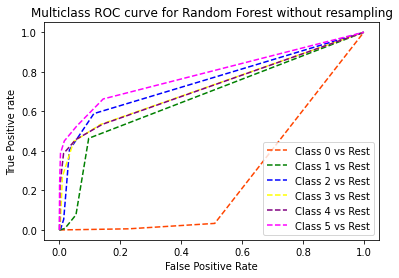

In [35]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_RF, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Random Forest without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Random Forest without resampling',dpi=300)

### Random Forest Algorithm without resampling - Hyperparameter Tuning

In [36]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [37]:
RF_random = RandomizedSearchCV(estimator = RF_classifier, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
RF_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=70,
                                                    n_estimators=20,
                                                    random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 14, 18, 23, 27, 32,
                                                         36, 41, 45, 50]},
                   random_state=0, verbose=2)

In [38]:
RF_random.best_params_

{'n_estimators': 50,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

### Random Forest Algorithm without resampling - Setting the right Hyperparameters

In [39]:
RF_classifier = RandomForestClassifier(n_estimators = 50, max_depth=80, bootstrap=False, max_features='sqrt', random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [40]:
pickle.dump(RF_classifier, open('RF_classifier6.pkl', 'wb'))

In [41]:
rf_accuracy = accuracy_score(y_test, y_pred_RF)
rf_precision = precision_score(y_test, y_pred_RF, average='weighted')
rf_recall = recall_score(y_test, y_pred_RF, average='weighted')
rf_f1_score = f1_score(y_test, y_pred_RF, average='weighted')
rf_cohen_kappa_score = cohen_kappa_score(y_test, y_pred_RF)

In [42]:
print('Performance of RF Algorithm without resampling - After Hyperparamter Tuning:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',rf_accuracy)
print('Precision:',rf_precision)
print('Recall:',rf_recall)
print('F1 Score:',rf_f1_score)
print('Cohen Kappa Score:',rf_cohen_kappa_score)

Performance of RF Algorithm without resampling - After Hyperparamter Tuning:

[[43413  1194   185    71    13     4]
 [ 3976  3150   513    62    13     0]
 [ 1473   771  1404   195    16     0]
 [  657   131   312   408    55     2]
 [  203    28    35    94   103    18]
 [   24     7     5     6    20    18]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     44880
           1       0.60      0.41      0.48      7714
           2       0.57      0.36      0.44      3859
           3       0.49      0.26      0.34      1565
           4       0.47      0.21      0.29       481
           5       0.43      0.23      0.30        80

    accuracy                           0.83     58579
   macro avg       0.57      0.41      0.46     58579
weighted avg       0.80      0.83      0.81     58579

Accuracy: 0.8278734700148518
Precision: 0.8023149084458648
Recall: 0.8278734700148518
F1 Score: 0.8080304723808558
Cohen Kappa Score: 0.48516897

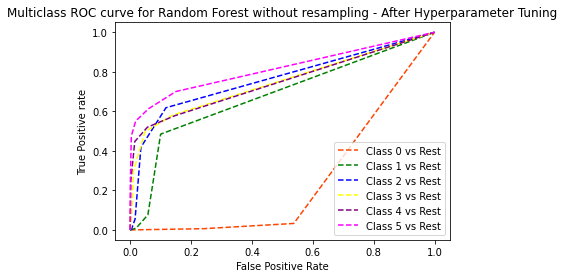

In [43]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_RF, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Random Forest without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Random Forest without resampling - After Hyperparameter Tuning',dpi=300)

## Performance Analysis

In [44]:
all_labels = pd.DataFrame()
all_labels['Actual_label'] = y_test
all_labels['y_pred_DT'] = y_pred_DT
all_labels['y_pred_RF'] = y_pred_RF

NameError: name 'y_pred_DT' is not defined

In [45]:
data = [
{'Algorithm':'Decision Tree without resampling' ,'Accuracy':dt_accuracy,'Precision':dt_precision,'Recall':dt_recall,'F1 Score':dt_f1_score,'Cohen Kappa Score':dt_cohen_kappa_score},
{'Algorithm':'Random Forest without resampling','Accuracy':rf_accuracy,'Precision':rf_precision,'Recall':rf_recall,'F1 Score':rf_f1_score,'Cohen Kappa Score':rf_cohen_kappa_score}
]
performance_metrics = pd.DataFrame(data)
performance_metrics.sort_values(by=['Accuracy', 'Cohen Kappa Score'], ascending=False)

NameError: name 'dt_accuracy' is not defined